<a href="https://colab.research.google.com/github/nhjung-phd/TimeSeriesAnalysis/blob/main/notebooks/04_BoxJenkins_Method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Box Jenkins Method

[*********************100%***********************]  1 of 1 completed


🔎 테슬라 주가(종가) - 상위 5개:
Date
2022-01-03    399.926666
2022-01-04    383.196655
2022-01-05    362.706665
2022-01-06    354.899994
2022-01-07    342.320007
Name: Close, dtype: float64

=== [원시계열에 대한 ADF 검정] ===
ADF Statistic: -2.8159
p-value:       0.056040
Critical Values:
   1%: -3.444
   5%: -2.867
   10%: -2.570
=> p-value >= 0.05 이므로, 비정상 시계열일 가능성이 큽니다. 차분 필요.



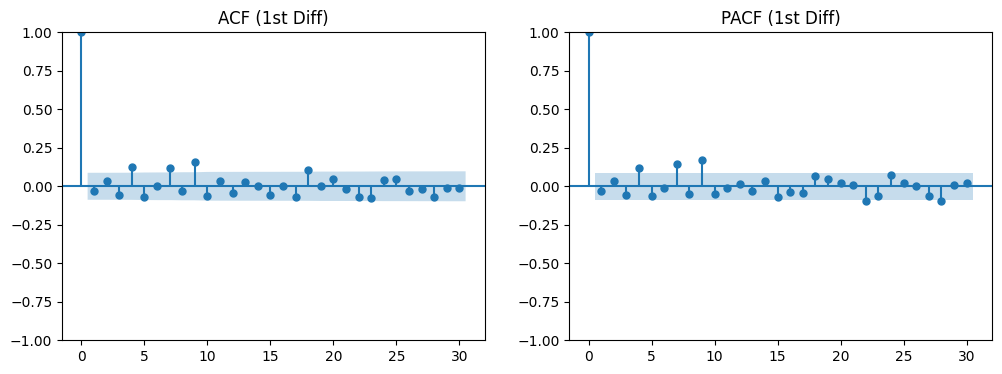

🔎 위 그래프(ACF, PACF)를 해석해 적절한 p,q를 선택하세요.
   예) ACF가 시차 1~2 부근에서 유의 ⇒ q=1 or 2, PACF가 시차 1에서 유의 ⇒ p=1 등

📌 예시로 p=1, d=1, q=1 로 진행합니다.

=== 모델: ARIMA(1,1,1) 추정 중... ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  501
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1814.100
Date:                Tue, 07 Oct 2025   AIC                           3634.200
Time:                        22:41:37   BIC                           3646.844
Sample:                             0   HQIC                          3639.162
                                - 501                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7150      0.280     -2.549      0.011      -1.265      -0.165
ma.L1          0.6627      0.302      2.196      0.028       0.071       1.254
sigma2        82.9718      4.021     20.634      0.0

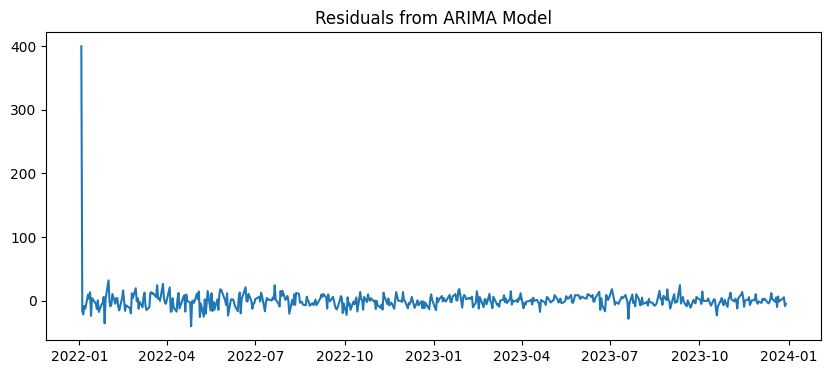

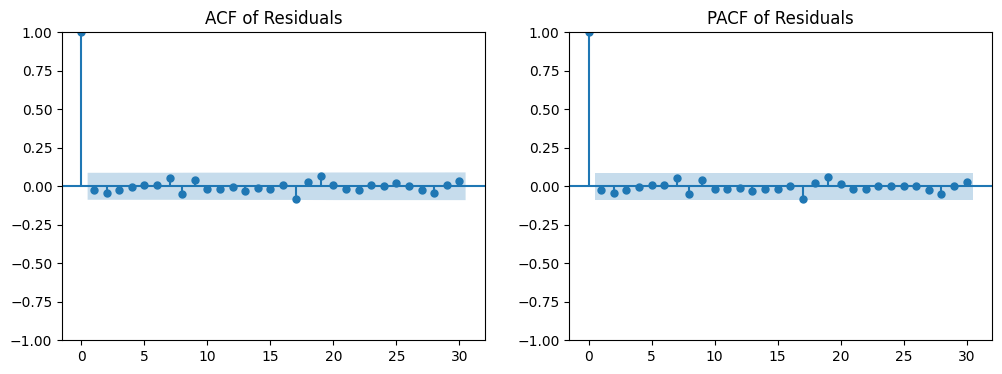

=== Ljung-Box Test (H0: Autocorrelation does NOT exist) ===
      lb_stat  lb_pvalue
10   5.387462   0.863839
20  12.617293   0.893194 

=== 향후 10일 예측 ===
501    248.516712
502    248.490459
503    248.509231
504    248.495809
505    248.505406
506    248.498544
507    248.503450
508    248.499942
509    248.502450
510    248.500657
Name: predicted_mean, dtype: float64


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


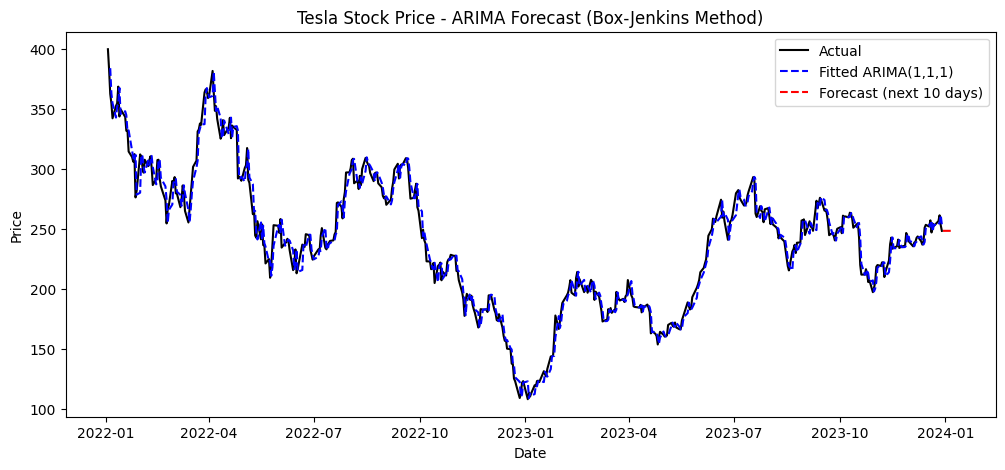

📌 In-sample MSE: 82.5832


In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# ADF 검정
from statsmodels.tsa.stattools import adfuller
# ACF/PACF 시각화
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# ARIMA
from statsmodels.tsa.arima.model import ARIMA
# 잔차진단 (Ljung-Box)
from statsmodels.stats.diagnostic import acorr_ljungbox
# 오차 지표
from sklearn.metrics import mean_squared_error

# -----------------------------
# 1) 데이터 수집 및 시계열 준비
# -----------------------------
df = yf.download("TSLA", start="2022-01-01", end="2024-01-01")
df.columns = df.columns.droplevel(1)  # MultiIndex 제거 (yfinance가 multiindex 반환 가능)
df.reset_index(inplace=True)

# 'Date'를 인덱스로 사용 & 'Close' 열만 시계열로 추출
df.set_index("Date", inplace=True)
ts_data = df["Close"].dropna()

print("🔎 테슬라 주가(종가) - 상위 5개:")
print(ts_data.head())
print()

# -----------------------------
# Step 1. 식별 (Identification)
#  - (a) 정상성 여부 확인 (ADF 검정)
#  - (b) 필요시 차분(differencing)
#  - (c) ACF / PACF 시각화로 (p, q) 대략 식별
# -----------------------------

# (a) ADF(단위근) 검정
adf_result = adfuller(ts_data, autolag="AIC")
adf_stat, adf_pval, usedlag, nobs, crit_vals, icbest = adf_result
print("=== [원시계열에 대한 ADF 검정] ===")
print(f"ADF Statistic: {adf_stat:.4f}")
print(f"p-value:       {adf_pval:.6f}")
print("Critical Values:")
for k, v in crit_vals.items():
    print(f"   {k}: {v:.3f}")

if adf_pval < 0.05:
    print("=> p-value < 0.05 이므로, 단위근(비정상) 귀무가설을 기각 → 정상성 시계열로 볼 수도 있습니다.\n")
    d = 0
else:
    print("=> p-value >= 0.05 이므로, 비정상 시계열일 가능성이 큽니다. 차분 필요.\n")
    d = 1  # 예시로 1차 차분 선택

# (b) (예시) d=1 로 가정 시, ARIMA(p,1,q) 모델 고려
#           실제론 ACF/PACF 보고 추가 차분(d=2) 필요할 수도 있음
if d > 0:
    diff_data = ts_data.diff().dropna()
    # ACF, PACF 시각화 (차분 시계열)
    fig, axes = plt.subplots(1, 2, figsize=(12,4))
    plot_acf(diff_data, ax=axes[0], lags=30)
    axes[0].set_title("ACF (1st Diff)")
    plot_pacf(diff_data, ax=axes[1], lags=30, method="ywm")
    axes[1].set_title("PACF (1st Diff)")
    plt.show()
else:
    # 원시계열에 대해 ACF/PACF
    fig, axes = plt.subplots(1, 2, figsize=(12,4))
    plot_acf(ts_data, ax=axes[0], lags=30)
    axes[0].set_title("ACF (Original)")
    plot_pacf(ts_data, ax=axes[1], lags=30, method="ywm")
    axes[1].set_title("PACF (Original)")
    plt.show()

print("🔎 위 그래프(ACF, PACF)를 해석해 적절한 p,q를 선택하세요.")
print("   예) ACF가 시차 1~2 부근에서 유의 ⇒ q=1 or 2, PACF가 시차 1에서 유의 ⇒ p=1 등\n")
p = 1
q = 1
print(f"📌 예시로 p={p}, d={d}, q={q} 로 진행합니다.\n")

# -----------------------------
# Step 2. 추정 (Estimation)
#  - (p, d, q) 모델을 잡고 파라미터 추정 (최대우도법)
# -----------------------------
print(f"=== 모델: ARIMA({p},{d},{q}) 추정 중... ===")
model = ARIMA(ts_data, order=(p, d, q))
model_fit = model.fit()
print(model_fit.summary())

# -----------------------------
# Step 3. 진단 (Diagnostic)
#  - 잔차(Residual) 분석: 자기상관, 정규성 등
# -----------------------------
residuals = model_fit.resid

# (a) 잔차 플롯
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title("Residuals from ARIMA Model")
plt.show()

# (b) 잔차 ACF -> 잔차에 유의미한 자기상관이 남아있지 않아야 함
fig, axes = plt.subplots(1,2,figsize=(12,4))
plot_acf(residuals, lags=30, ax=axes[0])
axes[0].set_title("ACF of Residuals")
plot_pacf(residuals, lags=30, ax=axes[1], method="ywm")
axes[1].set_title("PACF of Residuals")
plt.show()

# (c) Ljung-Box 테스트 -> 잔차가 백색잡음(독립)인지 검정
lb_test = acorr_ljungbox(residuals, lags=[10,20], return_df=True)
print("=== Ljung-Box Test (H0: Autocorrelation does NOT exist) ===")
print(lb_test, "\n")

# -----------------------------
# Step 4. 예측 (Forecast)
# -----------------------------

# (a) 학습데이터에 대한 In-sample 예측
#train_pred = model_fit.predict(start=ts_data.index[p+d:], end=ts_data.index[-1], typ="levels")
train_pred = model_fit.predict(start=p+d, end=len(ts_data)-1, typ="levels")  # Changed line: Use integer index for start and end


# (b) out-of-sample forecast 예 (향후 10일 예측)
steps_ahead = 10
future_forecast = model_fit.forecast(steps=steps_ahead)

print(f"=== 향후 {steps_ahead}일 예측 ===")
print(future_forecast)

# (c) 시각화
plt.figure(figsize=(12,5))
plt.plot(ts_data, label="Actual", color="black")

# In-sample 구간 예측
plt.plot(train_pred.index, train_pred, label=f"Fitted ARIMA({p},{d},{q})", linestyle="--", color="blue")

# 미래 예측 (끝 시점 이후)
last_date = ts_data.index[-1]
future_index = pd.date_range(start=last_date, periods=steps_ahead+1, freq="D")[1:]
plt.plot(future_index, future_forecast, label="Forecast (next 10 days)", linestyle="--", color="red")

plt.title("Tesla Stock Price - ARIMA Forecast (Box-Jenkins Method)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

# (d) (선택) 성능 평가 (학습데이터 기준)
mse_in_sample = mean_squared_error(ts_data.iloc[p+d:], train_pred)
print(f"📌 In-sample MSE: {mse_in_sample:.4f}")


[*********************100%***********************]  1 of 1 completed


🔎 테슬라 주가(종가) - 상위 5개:
Date
2022-01-03    399.926666
2022-01-04    383.196655
2022-01-05    362.706665
2022-01-06    354.899994
2022-01-07    342.320007
Name: Close, dtype: float64

=== [원시계열 ADF 검정] ===
ADF Statistic: -2.8159
p-value      : 0.056040
Critical Values:
   1%: -3.444
   5%: -2.867
   10%: -2.570
=> p>=0.05, 비정상 가능성 큼 → 차분(d=1) 시도.



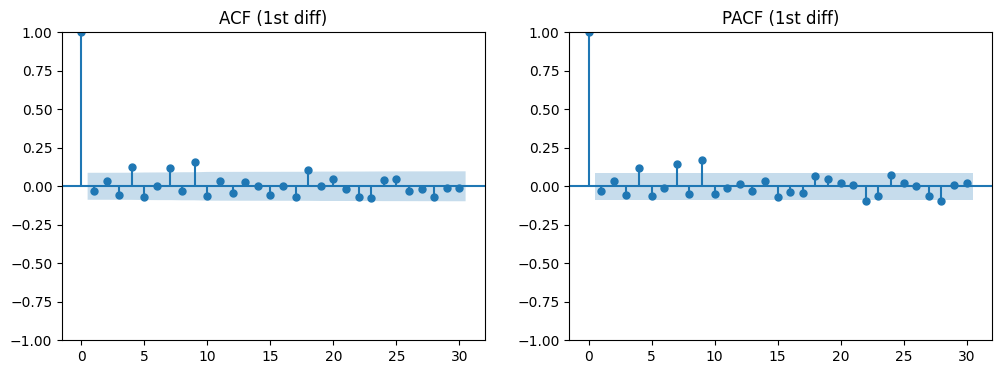

📌 (예시) ARIMA(1,1,1) 모델로 진행해 보겠습니다.

=== 모델: ARIMA(1,1,1) ===
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  501
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1814.100
Date:                Tue, 07 Oct 2025   AIC                           3634.200
Time:                        22:41:44   BIC                           3646.844
Sample:                             0   HQIC                          3639.162
                                - 501                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7150      0.280     -2.549      0.011      -1.265      -0.165
ma.L1          0.6627      0.302      2.196      0.028       0.071    

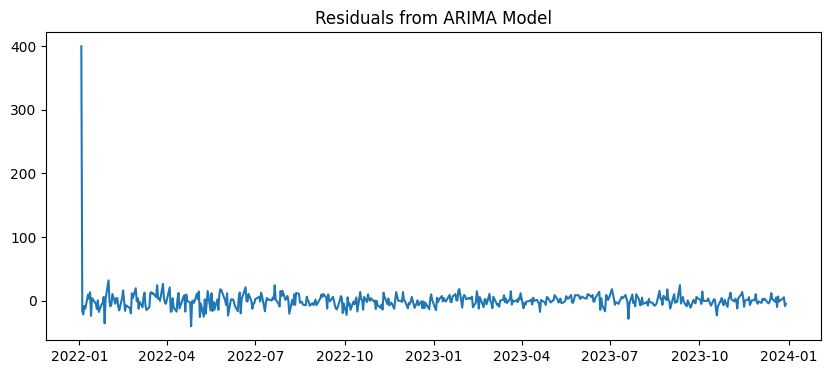

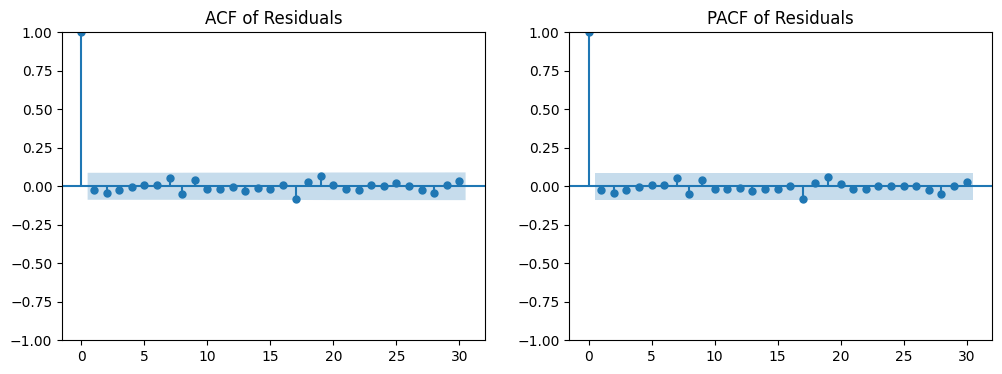

=== Ljung-Box Test (H0: No Autocorrelation in Residuals) ===
      lb_stat  lb_pvalue
10   5.387462   0.863839
20  12.617293   0.893194 

📌 [In-sample] MSE: 82.5832
=== 향후 10일 예측 ===
           Forecast
2023-12-30      NaN
2023-12-31      NaN
2024-01-01      NaN
2024-01-02      NaN
2024-01-03      NaN
2024-01-04      NaN
2024-01-05      NaN
2024-01-06      NaN
2024-01-07      NaN
2024-01-08      NaN



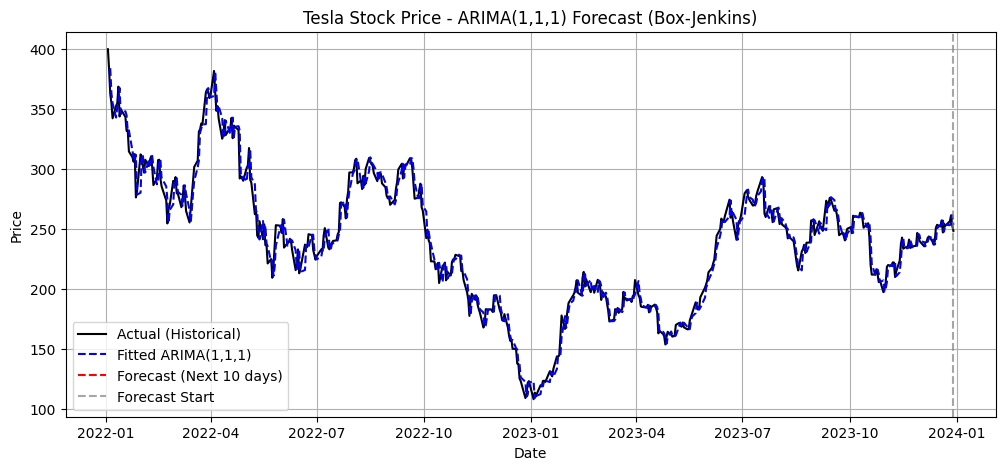

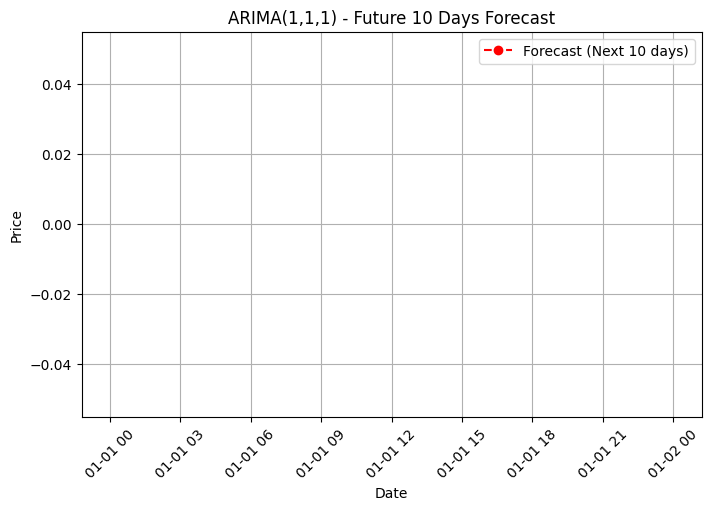

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# ADF 검정
from statsmodels.tsa.stattools import adfuller
# ACF/PACF 시각화
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# ARIMA
from statsmodels.tsa.arima.model import ARIMA
# 잔차진단 (Ljung-Box)
from statsmodels.stats.diagnostic import acorr_ljungbox
# 오차 지표
from sklearn.metrics import mean_squared_error


# -----------------------------
# 1) 데이터 수집 & 시계열 준비
# -----------------------------
df = yf.download("TSLA", start="2022-01-01", end="2024-01-01")
df.columns = df.columns.droplevel(1)  # MultiIndex 제거
df.reset_index(inplace=True)

# 'Date'를 인덱스로 사용 & 'Close' 열만 시계열로 추출
df.set_index("Date", inplace=True)
ts_data = df["Close"].dropna()

print("🔎 테슬라 주가(종가) - 상위 5개:")
print(ts_data.head())
print()


# -----------------------------
# Step 1. 식별 (Identification)
#    - ADF로 정상성 확인
#    - 필요시 차분
#    - ACF/PACF 확인하여 (p,q) 추정
# -----------------------------

# (a) ADF(단위근) 검정
adf_result = adfuller(ts_data, autolag="AIC")
adf_stat, adf_pval, usedlag, nobs, crit_vals, icbest = adf_result
print("=== [원시계열 ADF 검정] ===")
print(f"ADF Statistic: {adf_stat:.4f}")
print(f"p-value      : {adf_pval:.6f}")
print("Critical Values:")
for k, v in crit_vals.items():
    print(f"   {k}: {v:.3f}")

if adf_pval < 0.05:
    print("=> p<0.05, 비정상 귀무가설 기각 → 정상성(Stationary) 가능성.\n")
    d = 0
else:
    print("=> p>=0.05, 비정상 가능성 큼 → 차분(d=1) 시도.\n")
    d = 1

# (b) 차분 및 ACF/PACF 플롯
if d == 1:
    diff_data = ts_data.diff().dropna()
    fig, axes = plt.subplots(1,2, figsize=(12,4))
    plot_acf(diff_data, ax=axes[0], lags=30)
    axes[0].set_title("ACF (1st diff)")
    plot_pacf(diff_data, ax=axes[1], lags=30, method="ywm")
    axes[1].set_title("PACF (1st diff)")
    plt.show()
else:
    fig, axes = plt.subplots(1,2, figsize=(12,4))
    plot_acf(ts_data, ax=axes[0], lags=30)
    axes[0].set_title("ACF (Original)")
    plot_pacf(ts_data, ax=axes[1], lags=30, method="ywm")
    axes[1].set_title("PACF (Original)")
    plt.show()

# 예시로 p=1, q=1 지정
p = 1
q = 1
print(f"📌 (예시) ARIMA({p},{d},{q}) 모델로 진행해 보겠습니다.\n")


# -----------------------------
# Step 2. 추정 (Estimation)
#    - (p,d,q) 모델로 파라미터 추정
# -----------------------------
print(f"=== 모델: ARIMA({p},{d},{q}) ===")
model = ARIMA(ts_data, order=(p,d,q))
model_fit = model.fit()
print(model_fit.summary(), "\n")


# -----------------------------
# Step 3. 진단 (Diagnostic)
#    - 잔차(Residual) 분석
#    - Ljung-Box 테스트
# -----------------------------
residuals = model_fit.resid

# (a) 잔차 플롯
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title("Residuals from ARIMA Model")
plt.show()

# (b) 잔차 ACF/PACF
fig, axes = plt.subplots(1,2, figsize=(12,4))
plot_acf(residuals, lags=30, ax=axes[0])
axes[0].set_title("ACF of Residuals")
plot_pacf(residuals, lags=30, ax=axes[1], method="ywm")
axes[1].set_title("PACF of Residuals")
plt.show()

# (c) Ljung-Box
lb_test = acorr_ljungbox(residuals, lags=[10,20], return_df=True)
print("=== Ljung-Box Test (H0: No Autocorrelation in Residuals) ===")
print(lb_test, "\n")


# -----------------------------
# Step 4. 예측 (Forecast)
# -----------------------------

# (a) In-sample 예측 (모델 적합 확인)
train_pred = model_fit.predict(
    start=p+d,  # Changed to integer index position
    end=len(ts_data)-1,  # Changed to integer index position
    typ="levels"
)

mse_in_sample = mean_squared_error(ts_data.iloc[p+d:], train_pred)
print(f"📌 [In-sample] MSE: {mse_in_sample:.4f}")

# (b) Out-of-sample 예측 (향후 10일)
steps_ahead = 10
future_forecast = model_fit.forecast(steps=steps_ahead)

# 미래 날짜 인덱스 (마지막날 기준 10일)
last_date = ts_data.index[-1]
future_index = pd.date_range(start=last_date, periods=steps_ahead+1, freq="D")[1:]

print(f"=== 향후 {steps_ahead}일 예측 ===")
forecast_df = pd.DataFrame(future_forecast, index=future_index, columns=["Forecast"])
print(forecast_df)
print()


# -----------------------------
# 시각화: 실제 vs. 훈련 예측 vs. 미래 예측
# -----------------------------

# (c) 그래프 1: 전체 시계열 + In-sample 적합 + Out-of-sample 예측
plt.figure(figsize=(12,5))
plt.plot(ts_data.index, ts_data, label="Actual (Historical)", color="black")

# in-sample 적합
plt.plot(train_pred.index, train_pred, label=f"Fitted ARIMA({p},{d},{q})", linestyle="--", color="blue")

# out-of-sample forecast
plt.plot(forecast_df.index, forecast_df["Forecast"], label="Forecast (Next 10 days)", linestyle="--", color="red")

plt.axvline(x=ts_data.index[-1], color="gray", linestyle="--", alpha=0.7, label="Forecast Start")

plt.title(f"Tesla Stock Price - ARIMA({p},{d},{q}) Forecast (Box-Jenkins)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


# (d) 그래프 2: 예측 구간만 확대 (Out-of-sample)
plt.figure(figsize=(8,5))
plt.plot(forecast_df.index, forecast_df["Forecast"], label="Forecast (Next 10 days)", linestyle="--", color="red", marker='o')
plt.title(f"ARIMA({p},{d},{q}) - Future 10 Days Forecast")
plt.xlabel("Date")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


[*********************100%***********************]  1 of 1 completed


Rolling Forecast MSE: 50.369
Rolling Forecast R² : 0.834


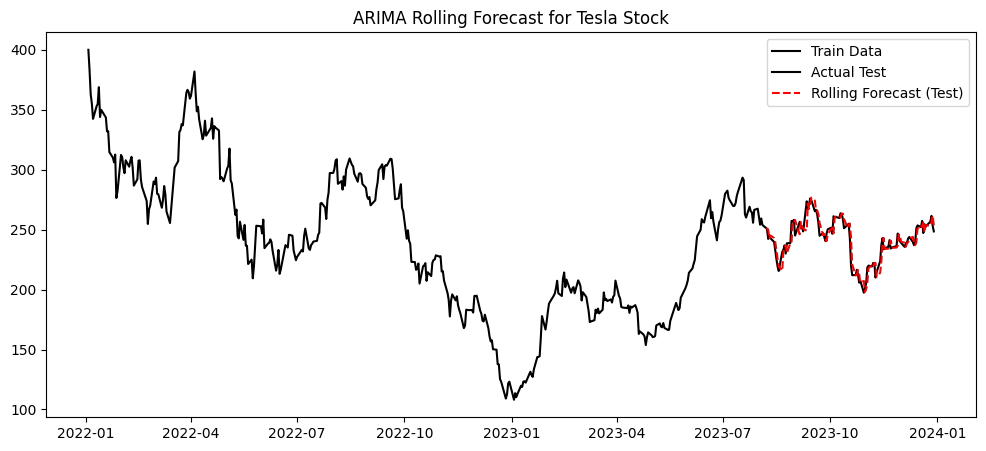

In [3]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score

# ◆ (a) 데이터 수집
df = yf.download("TSLA", start="2022-01-01", end="2024-01-01")
df.columns = df.columns.droplevel(1)  # MultiIndex 제거
df.reset_index(inplace=True)
df.set_index("Date", inplace=True)

ts_data = df["Close"].dropna()

# ◆ (b) 학습/테스트 분할
train_size = int(len(ts_data) * 0.8)
train_data = ts_data.iloc[:train_size]
test_data  = ts_data.iloc[train_size:]

# ◆ (c) 훈련데이터로 초기 ARIMA 파라미터 선정
#     (여기서는 (p,d,q) = (1,1,1) 고정 예시, 필요시 auto_arima)
p, d, q = 1, 1, 1

# ◆ (d) 롤링 예측(One-step)용 구조
rolling_predictions = []
history = train_data.copy()  # 초기 히스토리: 학습세트

for t in range(len(test_data)):
    # 1) 현재까지의 데이터(history)에 대해 ARIMA 재적합
    model = ARIMA(history, order=(p,d,q))
    model_fit = model.fit()

    # 2) 다음 시점(=test_data.index[t]) 예측
    pred = model_fit.forecast(steps=1)
    rolling_predictions.append(pred.iloc[0])

    # 3) 테스트 실제값(ground truth)을 history에 추가 → 다음 예측에 반영
    actual_value = test_data.iloc[t]
    history = pd.concat([history, pd.Series(actual_value, index=[test_data.index[t]])])

# ◆ (e) 결과 비교
rolling_preds_series = pd.Series(rolling_predictions, index=test_data.index)

mse_rolling = mean_squared_error(test_data, rolling_preds_series)
r2_rolling  = r2_score(test_data, rolling_preds_series)
print(f"Rolling Forecast MSE: {mse_rolling:.3f}")
print(f"Rolling Forecast R² : {r2_rolling:.3f}")

# ◆ (f) 시각화
plt.figure(figsize=(12,5))
plt.plot(train_data.index, train_data, label="Train Data", color="black")
plt.plot(test_data.index, test_data, label="Actual Test", color="black")
plt.plot(rolling_preds_series.index, rolling_preds_series,
         label="Rolling Forecast (Test)", color="red", linestyle="--")
plt.title("ARIMA Rolling Forecast for Tesla Stock")
plt.legend()
plt.show()


# Box-Jenkins ARIMA + Rolling Forecast



[*********************100%***********************]  1 of 1 completed


🔎 테슬라 주가(종가) - 상위 5개:
Date
2022-01-03    399.926666
2022-01-04    383.196655
2022-01-05    362.706665
2022-01-06    354.899994
2022-01-07    342.320007
Name: Close, dtype: float64

=== [원시계열 ADF 검정] ===
ADF Statistic: -2.8159
p-value      : 0.056040
Critical Values:
   1%: -3.444
   5%: -2.867
   10%: -2.570
=> p>=0.05, 비정상 가능성 큼 → 차분(d=1) 시도.



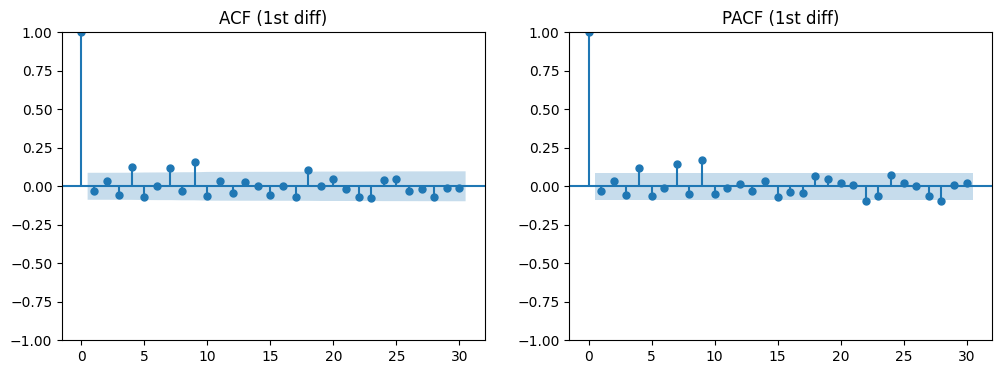

📌 (예시) ARIMA(1,1,1) 모델로 진행해 보겠습니다.

=== 모델: ARIMA(1,1,1) ===
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  501
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1814.100
Date:                Tue, 07 Oct 2025   AIC                           3634.200
Time:                        22:42:16   BIC                           3646.844
Sample:                             0   HQIC                          3639.162
                                - 501                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7150      0.280     -2.549      0.011      -1.265      -0.165
ma.L1          0.6627      0.302      2.196      0.028       0.071    

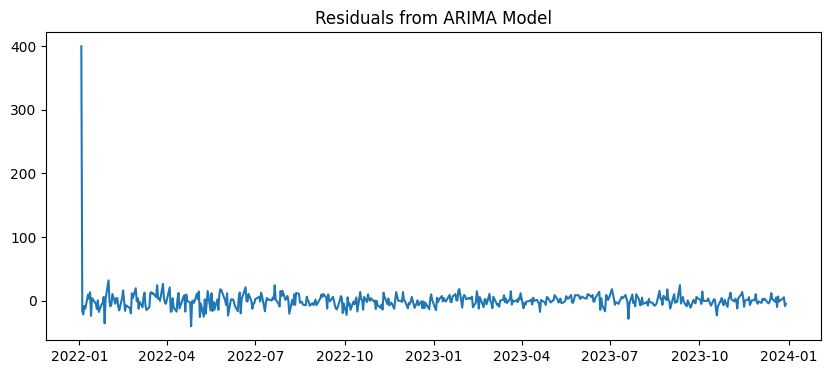

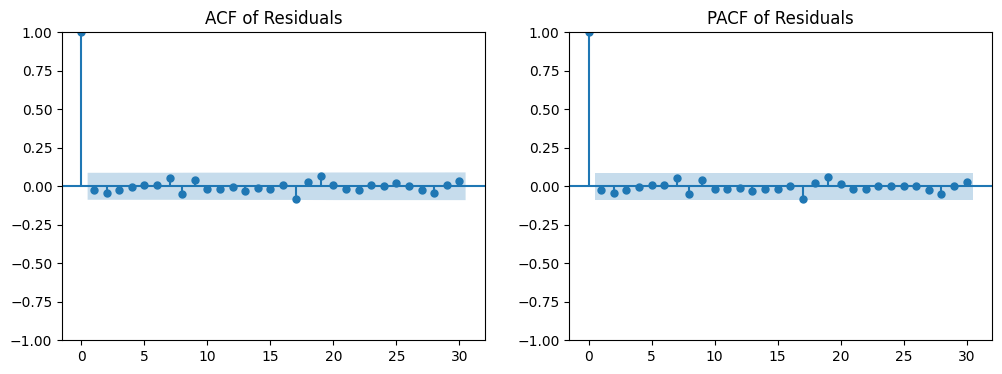

=== Ljung-Box Test (H0: No Autocorrelation in Residuals) ===
      lb_stat  lb_pvalue
10   5.387462   0.863839
20  12.617293   0.893194 

📌 [In-sample] MSE: 82.5832
=== 향후 10일 예측 ===
           Forecast
2023-12-30      NaN
2023-12-31      NaN
2024-01-01      NaN
2024-01-02      NaN
2024-01-03      NaN
2024-01-04      NaN
2024-01-05      NaN
2024-01-06      NaN
2024-01-07      NaN
2024-01-08      NaN



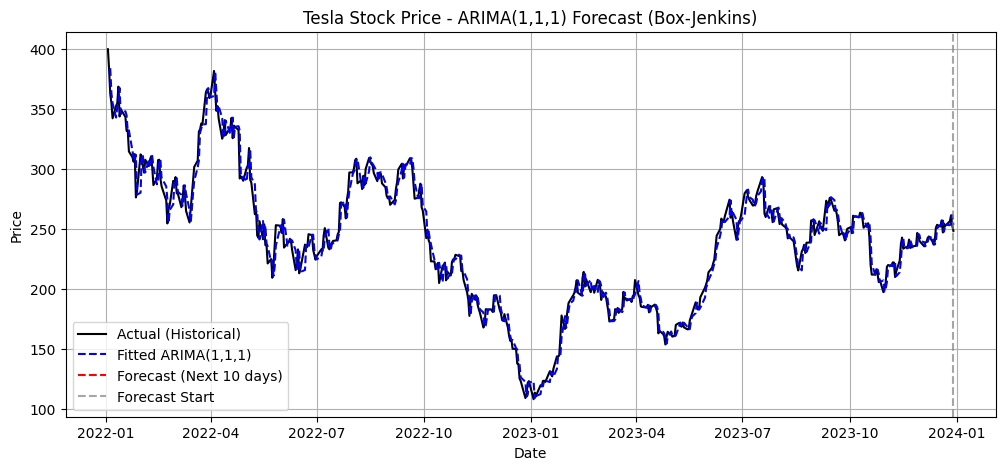

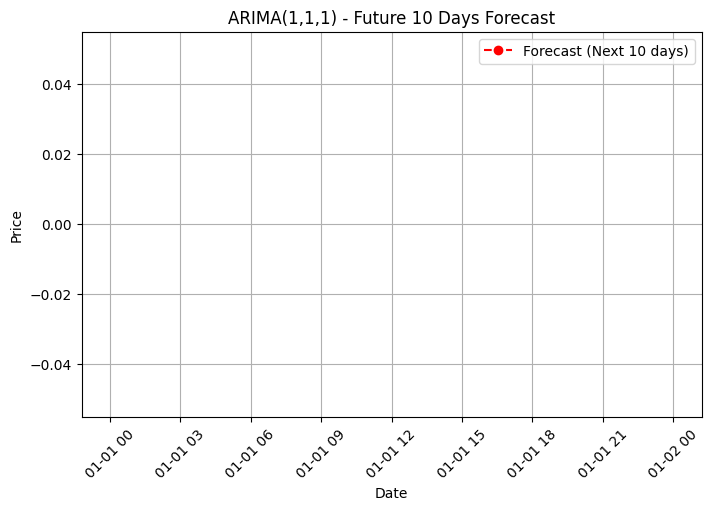

학습용 크기: 400 / 테스트용 크기: 101
=== Rolling Forecast (One-step) - Test 구간 ===
Rolling MSE : 50.3686
Rolling R²  : 0.8341


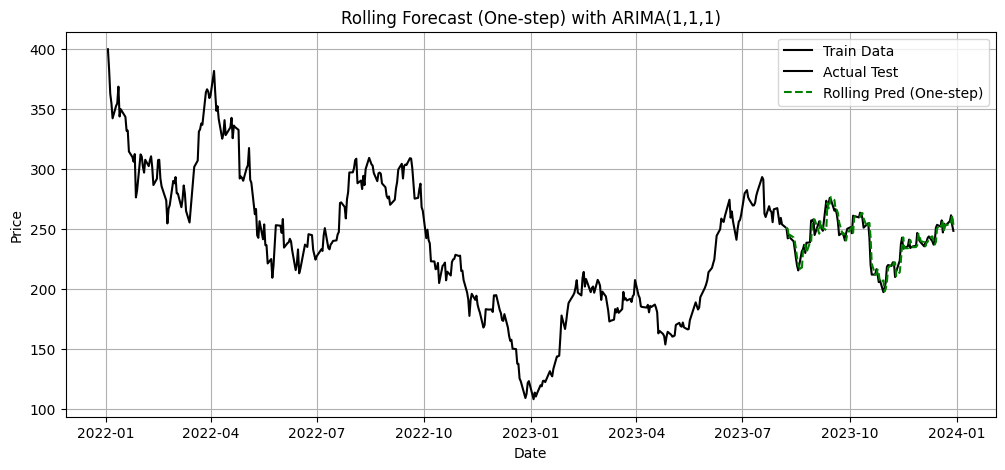

In [4]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# ADF 검정
from statsmodels.tsa.stattools import adfuller
# ACF/PACF 시각화
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# ARIMA
from statsmodels.tsa.arima.model import ARIMA
# 잔차진단 (Ljung-Box)
from statsmodels.stats.diagnostic import acorr_ljungbox
# 오차 지표
from sklearn.metrics import mean_squared_error, r2_score


# -----------------------------
# 1) 데이터 수집 & 시계열 준비
# -----------------------------
df = yf.download("TSLA", start="2022-01-01", end="2024-01-01")
df.columns = df.columns.droplevel(1)  # MultiIndex 제거
df.reset_index(inplace=True)

# 'Date'를 인덱스로 사용 & 'Close' 열만 시계열로 추출
df.set_index("Date", inplace=True)
ts_data = df["Close"].dropna()

print("🔎 테슬라 주가(종가) - 상위 5개:")
print(ts_data.head())
print()


# -----------------------------
# Step 1. 식별 (Identification)
#    - ADF로 정상성 확인
#    - 필요시 차분
#    - ACF/PACF 확인하여 (p,q) 추정
# -----------------------------

# (a) ADF(단위근) 검정
adf_result = adfuller(ts_data, autolag="AIC")
adf_stat, adf_pval, usedlag, nobs, crit_vals, icbest = adf_result
print("=== [원시계열 ADF 검정] ===")
print(f"ADF Statistic: {adf_stat:.4f}")
print(f"p-value      : {adf_pval:.6f}")
print("Critical Values:")
for k, v in crit_vals.items():
    print(f"   {k}: {v:.3f}")

if adf_pval < 0.05:
    print("=> p<0.05, 비정상 귀무가설 기각 → 정상성(Stationary) 가능성.\n")
    d = 0
else:
    print("=> p>=0.05, 비정상 가능성 큼 → 차분(d=1) 시도.\n")
    d = 1

# (b) 차분 및 ACF/PACF 플롯
if d == 1:
    diff_data = ts_data.diff().dropna()
    fig, axes = plt.subplots(1,2, figsize=(12,4))
    plot_acf(diff_data, ax=axes[0], lags=30)
    axes[0].set_title("ACF (1st diff)")
    plot_pacf(diff_data, ax=axes[1], lags=30, method="ywm")
    axes[1].set_title("PACF (1st diff)")
    plt.show()
else:
    fig, axes = plt.subplots(1,2, figsize=(12,4))
    plot_acf(ts_data, ax=axes[0], lags=30)
    axes[0].set_title("ACF (Original)")
    plot_pacf(ts_data, ax=axes[1], lags=30, method="ywm")
    axes[1].set_title("PACF (Original)")
    plt.show()

# 예시로 p=1, q=1 지정
p = 1
q = 1
print(f"📌 (예시) ARIMA({p},{d},{q}) 모델로 진행해 보겠습니다.\n")


# -----------------------------
# Step 2. 추정 (Estimation)
#    - (p,d,q) 모델로 파라미터 추정
# -----------------------------
print(f"=== 모델: ARIMA({p},{d},{q}) ===")
model = ARIMA(ts_data, order=(p,d,q))
model_fit = model.fit()
print(model_fit.summary(), "\n")


# -----------------------------
# Step 3. 진단 (Diagnostic)
#    - 잔차(Residual) 분석
#    - Ljung-Box 테스트
# -----------------------------
residuals = model_fit.resid

# (a) 잔차 플롯
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title("Residuals from ARIMA Model")
plt.show()

# (b) 잔차 ACF/PACF
fig, axes = plt.subplots(1,2, figsize=(12,4))
plot_acf(residuals, lags=30, ax=axes[0])
axes[0].set_title("ACF of Residuals")
plot_pacf(residuals, lags=30, ax=axes[1], method="ywm")
axes[1].set_title("PACF of Residuals")
plt.show()

# (c) Ljung-Box
lb_test = acorr_ljungbox(residuals, lags=[10,20], return_df=True)
print("=== Ljung-Box Test (H0: No Autocorrelation in Residuals) ===")
print(lb_test, "\n")


# -----------------------------
# Step 4. 예측 (Forecast) - 고정 모델 (Out-of-sample)
# -----------------------------

# (a) In-sample 예측 (모델 적합 확인)
train_pred = model_fit.predict(
    start=p+d,  # 정수 인덱스 위치
    end=len(ts_data)-1,
    typ="levels"
)

mse_in_sample = mean_squared_error(ts_data.iloc[p+d:], train_pred)
print(f"📌 [In-sample] MSE: {mse_in_sample:.4f}")

# (b) Out-of-sample 예측 (향후 10일)
steps_ahead = 10
future_forecast = model_fit.forecast(steps=steps_ahead)

# 미래 날짜 인덱스 (마지막날 기준 10일)
last_date = ts_data.index[-1]
future_index = pd.date_range(start=last_date, periods=steps_ahead+1, freq="D")[1:]

print(f"=== 향후 {steps_ahead}일 예측 ===")
forecast_df = pd.DataFrame(future_forecast, index=future_index, columns=["Forecast"])
print(forecast_df)
print()

# -----------------------------
# 시각화: 실제 vs. 훈련 예측 vs. 미래 예측
# -----------------------------
plt.figure(figsize=(12,5))
plt.plot(ts_data.index, ts_data, label="Actual (Historical)", color="black")
plt.plot(train_pred.index, train_pred, label=f"Fitted ARIMA({p},{d},{q})",
         linestyle="--", color="blue")
plt.plot(forecast_df.index, forecast_df["Forecast"], label="Forecast (Next 10 days)",
         linestyle="--", color="red")

plt.axvline(x=ts_data.index[-1], color="gray", linestyle="--", alpha=0.7, label="Forecast Start")
plt.title(f"Tesla Stock Price - ARIMA({p},{d},{q}) Forecast (Box-Jenkins)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


# (선택) 예측 구간만 확대
plt.figure(figsize=(8,5))
plt.plot(forecast_df.index, forecast_df["Forecast"], label="Forecast (Next 10 days)",
         linestyle="--", color="red", marker='o')
plt.title(f"ARIMA({p},{d},{q}) - Future 10 Days Forecast")
plt.xlabel("Date")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


# -----------------------------
# Step 5. (추가) 롤링(One-step) 예측
# -----------------------------

# (a) train/test 분할
train_ratio = 0.8
train_size = int(len(ts_data) * train_ratio)
train_data = ts_data.iloc[:train_size]
test_data  = ts_data.iloc[train_size:]

print(f"학습용 크기: {len(train_data)} / 테스트용 크기: {len(test_data)}")

# (b) 롤링 예측(One-step ahead)
rolling_preds = []
history = train_data.copy()

for i in range(len(test_data)):
    # 1) 현재 history로 모델 재적합
    rolling_model = ARIMA(history, order=(p,d,q))
    rolling_fit = rolling_model.fit()

    # 2) 다음 시점(= test_data의 i번째)에 대한 예측(1-step)
    pred = rolling_fit.forecast(steps=1)
    rolling_preds.append(pred.iloc[0])

    # 3) 실제값을 history에 추가
    actual_val = test_data.iloc[i]
    history = pd.concat([history, pd.Series(actual_val, index=[test_data.index[i]])])

rolling_preds_series = pd.Series(rolling_preds, index=test_data.index)

# (c) 롤링 예측 성능 측정
mse_rolling = mean_squared_error(test_data, rolling_preds_series)
r2_rolling  = r2_score(test_data, rolling_preds_series)
print(f"=== Rolling Forecast (One-step) - Test 구간 ===")
print(f"Rolling MSE : {mse_rolling:.4f}")
print(f"Rolling R²  : {r2_rolling:.4f}")

# (d) 롤링 예측 시각화
plt.figure(figsize=(12,5))
plt.plot(train_data.index, train_data, label="Train Data", color="black")
plt.plot(test_data.index, test_data, label="Actual Test", color="black")
plt.plot(rolling_preds_series.index, rolling_preds_series,
         label="Rolling Pred (One-step)", linestyle="--", color="green")
plt.title(f"Rolling Forecast (One-step) with ARIMA({p},{d},{q})")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


[*********************100%***********************]  1 of 1 completed


🔎 테슬라 종가 상위 5개:
Ticker            TSLA
Date                  
2025-01-02  379.279999
2025-01-03  410.440002
2025-01-06  411.049988
2025-01-07  394.359985
2025-01-08  394.940002 

Samples: total=185, train=148, test=37

=== [원시계열 ADF 검정] ===
ADF Statistic: -1.0521
p-value      : 0.733788
Critical Values: {'1%': np.float64(-3.466), '5%': np.float64(-2.877), '10%': np.float64(-2.575)}
→ p<0.05면 정상성 가정 가능, 아니면 차분(d) 필요.



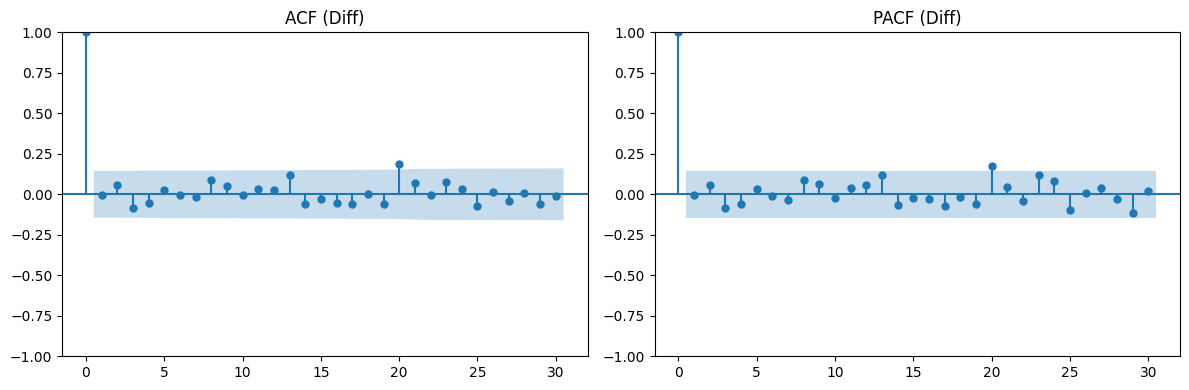

💡 ACF/PACF로 p,q 감 잡고, 아래 그리드서치가 최종 (p,d,q) 선택(AIC 기준)에 사용됩니다.

[Full] best (p,d,q): (3, 2, 5)


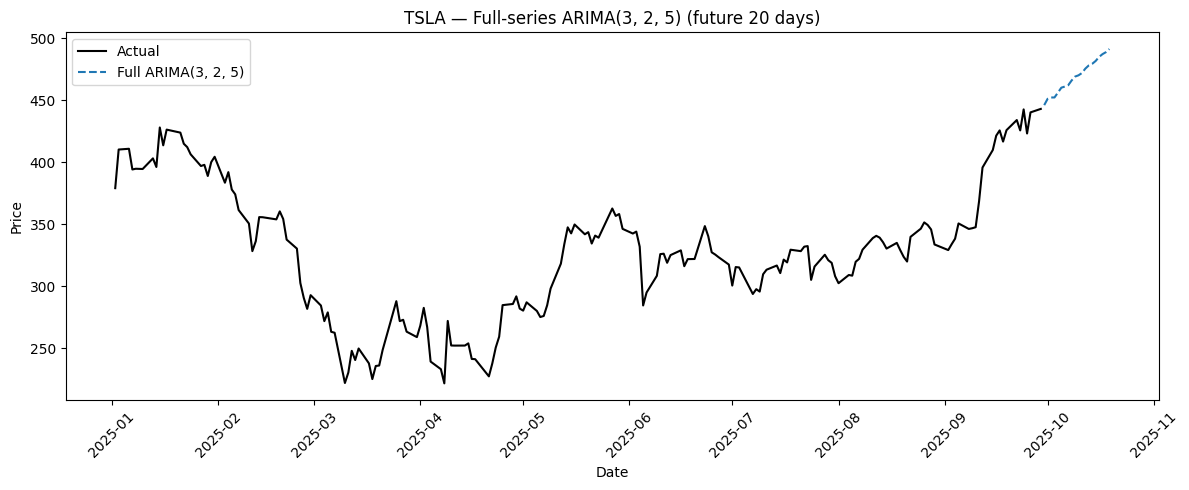

▶ Full: 전체 구간으로 모델을 한 번 적합하여 미래를 예측(평가엔 부적절, 시나리오/최종 적합용).

[Fixed-origin] best (p,d,q): (3, 2, 5)
[Fixed-origin] RMSE=66.4906 | MAE=51.4099 | R2=-1.5752


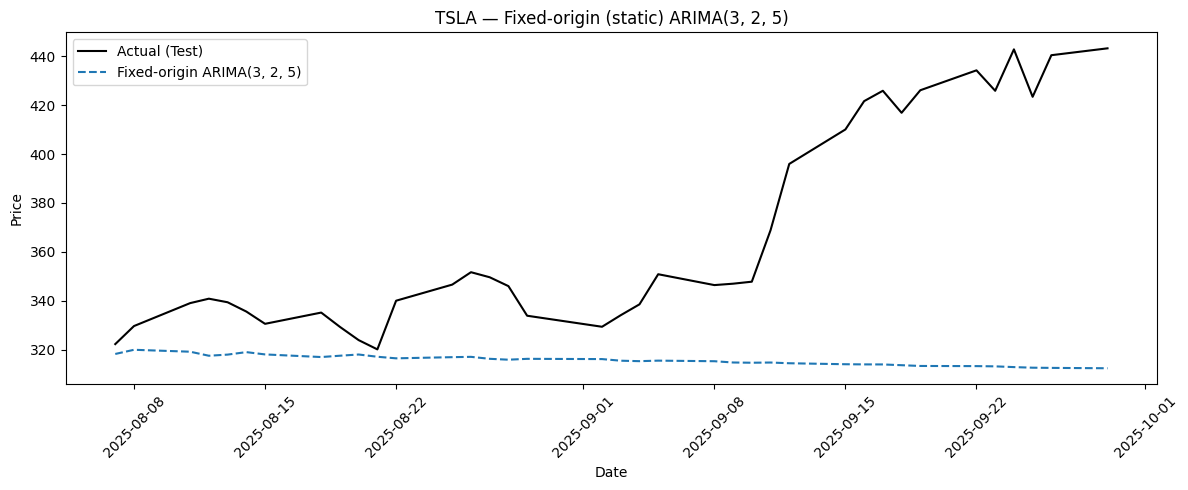

▶ Fixed-origin: 학습 한 번 적합 후 테스트 전구간에 그대로 적용(빠르나 구조 변화에 둔감).

[Rolling] RMSE=59.4774 | MAE=44.7423 | R2=0.9453


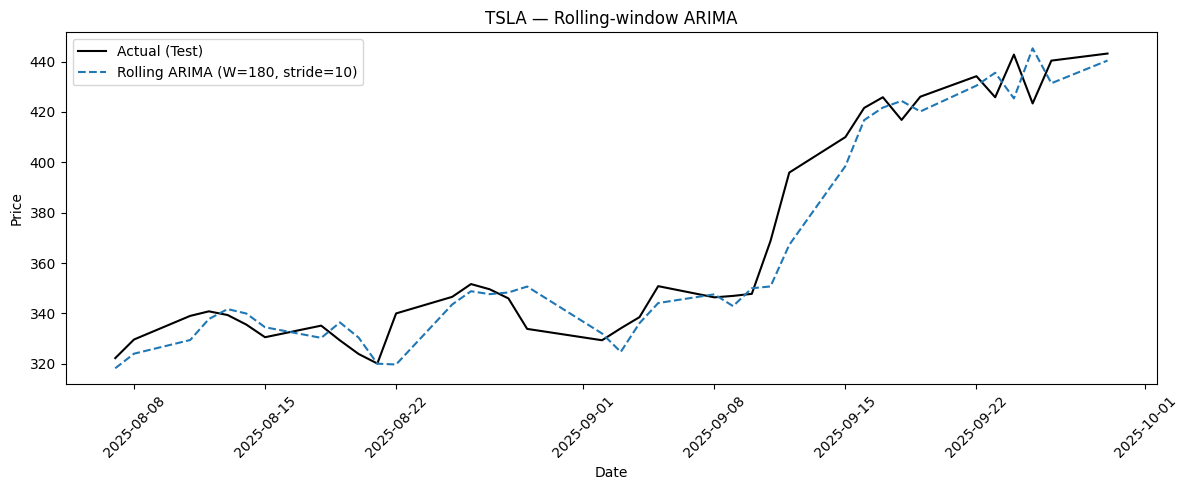

▶ Rolling: 고정 창 W로 최신성에 민감(드리프트 대응). 오래된 정보는 버려져 데이터 낭비 가능.

[Expanding] RMSE=59.3334 | MAE=44.6352 | R2=0.9438


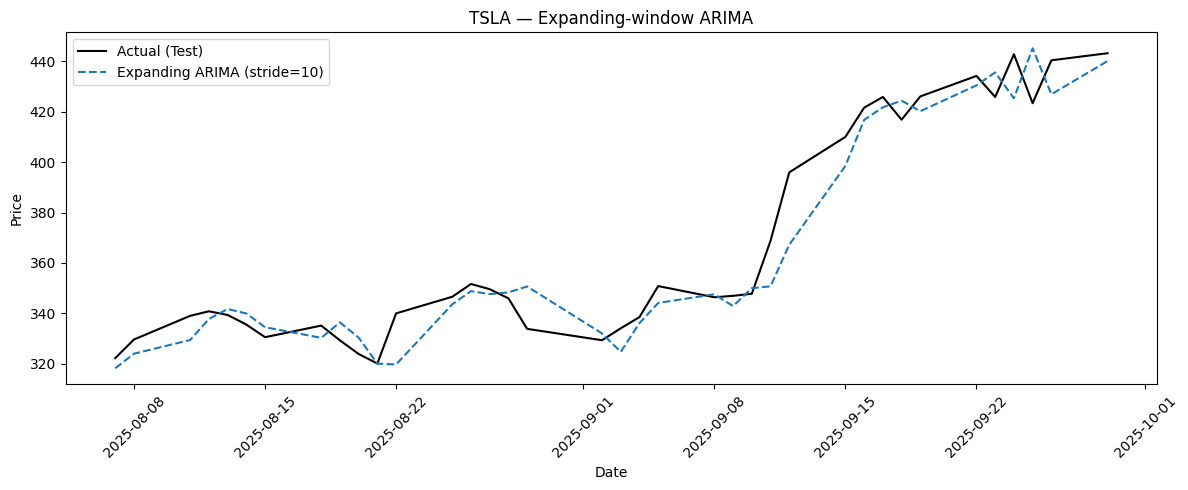

▶ Expanding: 데이터 누적 활용으로 안정성↑(분산↓). 변화 적응은 Rolling보다 느리고 계산량↑.

=== Ljung–Box Test on static model residuals (H0: no autocorr) ===
      lb_stat  lb_pvalue
10  17.353293   0.066903
20  18.047239   0.584296 



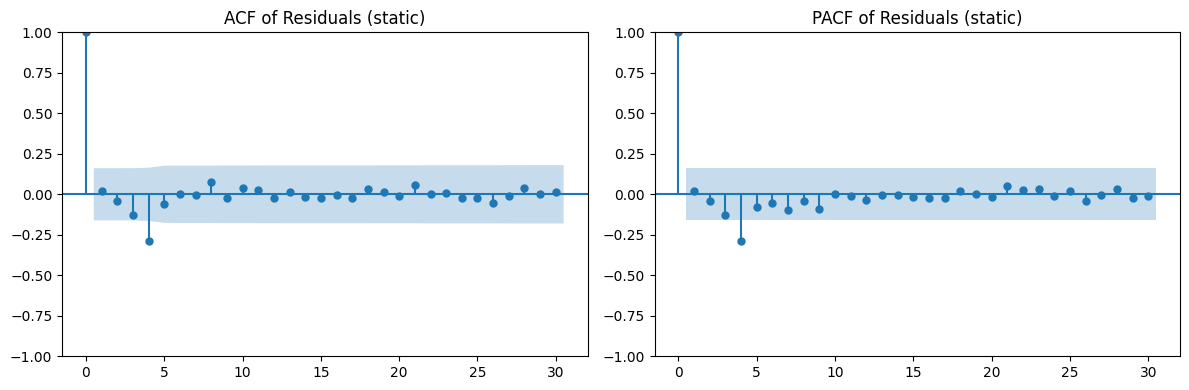


=== Summary on Test (lower RMSE/MAE is better, R2→1) ===


,Method,RMSE,MAE,R2
2,Expanding ARIMA (stride=10),59.333402,44.635196,0.943809
1,"Rolling ARIMA (W=180, stride=10)",59.477375,44.742320,0.945321
0,"Fixed-origin ARIMA(3, 2, 5)",66.490550,51.409906,-1.575173


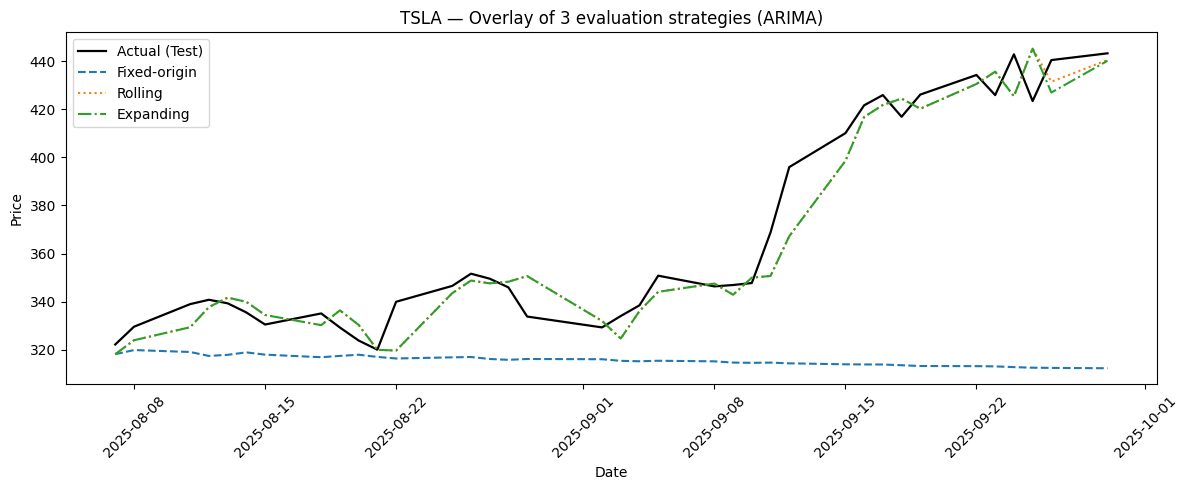

In [5]:
# ==================== Colab 준비 (필요 시 한 번만) ====================
# %pip -q install yfinance statsmodels scikit-learn pandas numpy matplotlib

# ==================== 0. 공용 임포트 & 경고 억제 ====================
import warnings
warnings.filterwarnings("ignore")  # 노이즈 최소화

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# Box–Jenkins: 식별/진단용
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

# ARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# 평가
from sklearn.metrics import r2_score

warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", message="Non-invertible")
warnings.filterwarnings("ignore", message="Maximum Likelihood")
warnings.filterwarnings("ignore", message="No frequency information")

plt.rcParams["figure.figsize"] = (12, 5)

# ==================== 1) 데이터 수집 & 시계열 준비 ====================
symbol, start_date, end_date = "TSLA", "2025-01-01", "2025-09-30"
df = yf.download(symbol, start=start_date, end=end_date).reset_index()
df = df[["Date", "Close"]].dropna().copy()
df["Date"] = pd.to_datetime(df["Date"])
ts = df.set_index("Date")["Close"]

print("🔎 테슬라 종가 상위 5개:")
print(ts.head(), "\n")

y = ts.to_numpy(float)
dates = ts.index.to_numpy()
split_idx = int(len(y) * 0.8)
y_train, y_test = y[:split_idx], y[split_idx:]
dates_train, dates_test = dates[:split_idx], dates[split_idx:]
print(f"Samples: total={len(y)}, train={len(y_train)}, test={len(y_test)}\n")

# ==================== 2) Box–Jenkins Step 1 — 식별(Identification) ====================
# 2-1) ADF(단위근) 검정으로 대략적인 d 결정
adf_stat, adf_pval, usedlag, nobs, crit, icbest = adfuller(y, autolag="AIC")
print("=== [원시계열 ADF 검정] ===")
print(f"ADF Statistic: {adf_stat:.4f}")
print(f"p-value      : {adf_pval:.6f}")
print("Critical Values:", {k: round(v, 3) for k, v in crit.items()})
print("→ p<0.05면 정상성 가정 가능, 아니면 차분(d) 필요.\n")

# d 초기 후보 (간단 규칙)
d0 = 0 if adf_pval < 0.05 else 1
D_SET = tuple(sorted(set([max(0, d0-1), d0, min(2, d0+1)])))  # {d0-1,d0,d0+1}∩[0,2]

# 2-2) (참고) ACF/PACF 플롯: d0 기준
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
series_for_plot = ts.diff(d0).dropna() if d0 > 0 else ts
plot_acf(series_for_plot, lags=30, ax=axes[0])
axes[0].set_title(f"ACF ({'Diff' if d0>0 else 'Original'})")
plot_pacf(series_for_plot, lags=30, ax=axes[1], method="ywm")
axes[1].set_title(f"PACF ({'Diff' if d0>0 else 'Original'})")
plt.tight_layout(); plt.show()

print("💡 ACF/PACF로 p,q 감 잡고, 아래 그리드서치가 최종 (p,d,q) 선택(AIC 기준)에 사용됩니다.\n")

# ==================== 3) 유틸 함수 (추정/선택/평가) ====================
def rmse(a, b): a,b=np.asarray(a,float),np.asarray(b,float); return float(np.sqrt(np.mean((a-b)**2)))
def mae(a, b):  a,b=np.asarray(a,float),np.asarray(b,float); return float(np.mean(np.abs(a-b)))
def r2(a, b):   return float(r2_score(np.asarray(a,float), np.asarray(b,float)))

def fit_arima_safe(y_win, order, maxiter=400):
    """ARIMA 안전 적합: 실패 시 None 반환."""
    p,d,q = map(int, order)
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model = ARIMA(y_win, order=(p,d,q), trend="n",
                          enforce_stationarity=False, enforce_invertibility=False)
            fit = model.fit(method_kwargs={"maxiter": maxiter, "disp": 0})
        return fit
    except Exception:
        return None

def select_arima_order(y_win, p_max=5, d_set=(0,1,2), q_max=5):
    """간단 AIC 그리드서치로 (p,d,q) 선택."""
    y_win = np.asarray(y_win, float)
    best, best_aic = None, np.inf
    for d in d_set:
        for p in range(p_max+1):
            for q in range(q_max+1):
                if (p,d,q) == (0,0,0):  # 무의미한 케이스 제외
                    continue
                fit = fit_arima_safe(y_win, (p,d,q), maxiter=500)
                if fit is None:
                    continue
                aic = getattr(fit, "aic", np.inf)
                if np.isfinite(aic) and aic < best_aic:
                    best_aic, best = aic, (p,d,q)
    return best if best is not None else (1,1,1)

# 탐색 범위
P_MAX, Q_MAX = 5, 5

# Rolling/Expanding 설정
W = 180               # Rolling 창 길이(약 9개월, 필요시 조정)
RESELECT_STRIDE = 10  # 몇 스텝마다 (p,d,q) 재선택할지
ADAPT_ORDER = True    # True면 Rolling/Expanding에서 (p,d,q)도 주기적으로 재선택

# Full 시나리오 미래 예측 길이
H_FUTURE = 20

# ==================== 4) A — Full series ====================
# 전체 데이터로 (p,d,q) 선택 → 계수 추정 → 미래 H_FUTURE일 예측
best_full = select_arima_order(y, p_max=P_MAX, d_set=D_SET, q_max=Q_MAX)
print(f"[Full] best (p,d,q): {best_full}")
fit_full = fit_arima_safe(y, best_full, maxiter=800)
y_future = fit_full.forecast(steps=H_FUTURE).astype(float) if fit_full is not None else np.full(H_FUTURE, y[-1])
future_dates = pd.date_range(dates[-1] + pd.Timedelta(days=1), periods=H_FUTURE, freq="D")

plt.figure()
plt.plot(dates, y, label="Actual", color="black")
plt.plot(future_dates, y_future, label=f"Full ARIMA{best_full}", linestyle="--")
plt.title(f"{symbol} — Full-series ARIMA{best_full} (future {H_FUTURE} days)")
plt.xlabel("Date"); plt.ylabel("Price"); plt.xticks(rotation=45); plt.legend(); plt.tight_layout(); plt.show()

print("▶ Full: 전체 구간으로 모델을 한 번 적합하여 미래를 예측(평가엔 부적절, 시나리오/최종 적합용).\n")

# ==================== 5) B — Fixed-origin (정적 파라미터) ====================
# 학습 80%로 (p,d,q) 선택 → 계수 고정 → 테스트 전구간 동시 예측
best_fix = select_arima_order(y_train, p_max=P_MAX, d_set=D_SET, q_max=Q_MAX)
print(f"[Fixed-origin] best (p,d,q): {best_fix}")
fit_static = fit_arima_safe(y_train, best_fix, maxiter=800)
y_pred_static = fit_static.forecast(steps=len(y_test)).astype(float) if fit_static is not None else np.full(len(y_test), y_train[-1])

rmse_b, mae_b, r2_b = rmse(y_test, y_pred_static), mae(y_test, y_pred_static), r2(y_test, y_pred_static)
print(f"[Fixed-origin] RMSE={rmse_b:.4f} | MAE={mae_b:.4f} | R2={r2_b:.4f}")

plt.figure()
plt.plot(dates_test, y_test, label="Actual (Test)", color="black")
plt.plot(dates_test, y_pred_static, label=f"Fixed-origin ARIMA{best_fix}", linestyle="--")
plt.title(f"{symbol} — Fixed-origin (static) ARIMA{best_fix}")
plt.xlabel("Date"); plt.ylabel("Price"); plt.xticks(rotation=45); plt.legend(); plt.tight_layout(); plt.show()

print("▶ Fixed-origin: 학습 한 번 적합 후 테스트 전구간에 그대로 적용(빠르나 구조 변화에 둔감).\n")

# ==================== 6) C — Rolling window ====================
# 매 시점마다 최근 W개로 재적합하여 1-step ahead 예측
pred_roll = np.full(len(y_test), np.nan, float)
hist = y_train.copy()
current_order = None

for i in range(len(y_test)):
    y_win = hist[-W:] if len(hist) >= W else hist
    # 주기적 (p,d,q) 재선택
    if ADAPT_ORDER and ((i % RESELECT_STRIDE == 0) or (current_order is None)):
        current_order = select_arima_order(y_win, p_max=P_MAX, d_set=D_SET, q_max=Q_MAX)
    elif current_order is None:
        current_order = best_fix  # 초기에는 fixed 모델 차수 재사용

    fit = fit_arima_safe(y_win, current_order, maxiter=600)
    if fit is not None:
        pred_roll[i] = float(fit.forecast(steps=1)[0])
    else:
        k = min(10, len(y_win))
        pred_roll[i] = float(np.mean(y_win[-k:]))

    # 워크-포워드(실제값으로 창 갱신)
    hist = np.append(hist, y_test[i])

rmse_c, mae_c, r2_c = rmse(y_test, pred_roll), mae(y_test, pred_roll), r2(y_test, pred_roll)
print(f"[Rolling] RMSE={rmse_c:.4f} | MAE={mae_c:.4f} | R2={r2_c:.4f}")

plt.figure()
plt.plot(dates_test, y_test, label="Actual (Test)", color="black")
plt.plot(dates_test, pred_roll, label=f"Rolling ARIMA (W={W}, stride={RESELECT_STRIDE})", linestyle="--")
plt.title(f"{symbol} — Rolling-window ARIMA")
plt.xlabel("Date"); plt.ylabel("Price"); plt.xticks(rotation=45); plt.legend(); plt.tight_layout(); plt.show()

print("▶ Rolling: 고정 창 W로 최신성에 민감(드리프트 대응). 오래된 정보는 버려져 데이터 낭비 가능.\n")

# ==================== 7) D — Expanding window ====================
# 1~t-1까지 누적 데이터로 매 시점 재적합하여 1-step ahead 예측
pred_exp = np.full(len(y_test), np.nan, float)
hist = y_train.copy()
current_order = None

for i in range(len(y_test)):
    if ADAPT_ORDER and ((i % RESELECT_STRIDE == 0) or (current_order is None)):
        current_order = select_arima_order(hist, p_max=P_MAX, d_set=D_SET, q_max=Q_MAX)
    elif current_order is None:
        current_order = best_fix

    fit = fit_arima_safe(hist, current_order, maxiter=600)
    if fit is not None:
        pred_exp[i] = float(fit.forecast(steps=1)[0])
    else:
        k = min(10, len(hist))
        pred_exp[i] = float(np.mean(hist[-k:]))

    hist = np.append(hist, y_test[i])

rmse_d, mae_d, r2_d = rmse(y_test, pred_exp), mae(y_test, pred_exp), r2(y_test, pred_exp)
print(f"[Expanding] RMSE={rmse_d:.4f} | MAE={mae_d:.4f} | R2={r2_d:.4f}")

plt.figure()
plt.plot(dates_test, y_test, label="Actual (Test)", color="black")
plt.plot(dates_test, pred_exp, label=f"Expanding ARIMA (stride={RESELECT_STRIDE})", linestyle="--")
plt.title(f"{symbol} — Expanding-window ARIMA")
plt.xlabel("Date"); plt.ylabel("Price"); plt.xticks(rotation=45); plt.legend(); plt.tight_layout(); plt.show()

print("▶ Expanding: 데이터 누적 활용으로 안정성↑(분산↓). 변화 적응은 Rolling보다 느리고 계산량↑.\n")

# ==================== 8) 진단(Diagnostic) — 정적 모델 기준 예시 ====================
# (Box–Jenkins 3단계) 잔차가 백색잡음인지 확인(Ljung–Box)
if fit_static is not None:
    resid = fit_static.resid
    lb = acorr_ljungbox(resid, lags=[10,20], return_df=True)
    print("=== Ljung–Box Test on static model residuals (H0: no autocorr) ===")
    print(lb, "\n")

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    plot_acf(resid, lags=30, ax=axes[0]); axes[0].set_title("ACF of Residuals (static)")
    plot_pacf(resid, lags=30, ax=axes[1], method="ywm"); axes[1].set_title("PACF of Residuals (static)")
    plt.tight_layout(); plt.show()

# ==================== 9) 요약 & 오버레이 ====================
summary = pd.DataFrame({
    "Method": [
        f"Fixed-origin ARIMA{best_fix}",
        f"Rolling ARIMA (W={W}, stride={RESELECT_STRIDE})",
        f"Expanding ARIMA (stride={RESELECT_STRIDE})"
    ],
    "RMSE": [rmse_b, rmse_c, rmse_d],
    "MAE":  [mae_b,  mae_c,  mae_d],
    "R2":   [r2_b,   r2_c,   r2_d]
})
print("\n=== Summary on Test (lower RMSE/MAE is better, R2→1) ===")
display(summary.sort_values("RMSE"))

plt.figure()
plt.plot(dates_test, y_test, label="Actual (Test)", color="black", linewidth=1.6)
plt.plot(dates_test, y_pred_static, label="Fixed-origin", linestyle="--")
plt.plot(dates_test, pred_roll,     label="Rolling",     linestyle=":")
plt.plot(dates_test, pred_exp,      label="Expanding",   linestyle="-.")
plt.title(f"{symbol} — Overlay of 3 evaluation strategies (ARIMA)")
plt.xlabel("Date"); plt.ylabel("Price"); plt.xticks(rotation=45); plt.legend(); plt.tight_layout(); plt.show()
